In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import h5py
import seaborn as sns
from scipy.special import logit
from scipy.special import expit
from scipy.interpolate import RegularGridInterpolator
from pylab import rcParams
import sys
import torch
import scipy
import corner
import copy

import sys
sys.path.append('../')
from populations.bbh_models import read_hdf5
from populations.bbh_models import get_models
from populations.Flowsclass_dev import FlowModel
from populations.utils.bounded_Nd_kde import Bounded_Nd_kde

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


glasflow is using its own internal version of nflows


In [2]:
#flags/inputs:
param = ['mchirp','q', 'chieff', 'z']
no_params = len(param)
channel_label = 'CE'

channel_ids = {'CE':0, 'CHE':1,'GC':2,'NSC':3, 'SMT':4}
channel_id = channel_ids[channel_label] #will be 0, 1, 2, 3, or 4
chi_b = [0.0,0.1,0.2,0.5]
alpha_CE = [0.2,0.5,1.0,2.,5.]
channel_samples = [4e6,864124,896611,582961, 4e6]
no_binaries = int(channel_samples[channel_id])
batch_size = 10000
total_hps=20

models_path ='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
#models_path ='/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/testing_notebooks/flow_samples.hdf5'
popsynth_outputs = read_hdf5(models_path, channel_label) # read all data from hdf5 file

models_dict = dict.fromkeys(popsynth_outputs.keys())
weights_dict = dict.fromkeys(popsynth_outputs.keys())


for key in popsynth_outputs.keys():
    models_dict[key] = popsynth_outputs[key][param]
    weights_dict[key]= popsynth_outputs[key]['weight']


In [3]:
#check that these distributions are the same between the whole (transformed distribution), batch, and the same for validation data
#no_trans, no_neurons, training_inputs, cond_inputs,no_binaries, batch_size, total_hps, RNVP=True, num_bins=4, device="cpu"):
flow = FlowModel(channel_label, popsynth_outputs, param)
weighted_flow = FlowModel(channel_label, popsynth_outputs, param, no_bins=5)
model_names, KDE_models = get_models(models_path, [channel_label], param, use_flows=False, spin_distr=None, normalize=False, detectable=False)
#_, KDE_models_detectable = get_models(models_path, [channel_label], param, use_flows=False, spin_distr=None, sensitivity='midhighlatelow_network', normalize=False, detectable=True)


100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


In [4]:
#inputs: x, data, pop_models, submodels_dict, channels, use_flows
hyperparams = list(set([x.split('/', 1)[1] for x in model_names]))
Nhyper = np.max([len(x.split('/')) for x in hyperparams])
channels = sorted(list(set([x.split('/')[0] for x in model_names])))

# construct dict that relates submodels to their index number
submodels_dict = {} #dummy index dict keys:0,1,2,3, items: particular models
ctr=0 #associates with either chi_b or alpha (0 or 1)
while ctr < Nhyper:
    submodels_dict[ctr] = {}
    hyper_set = sorted(list(set([x.split('/')[ctr] for x in hyperparams])))
    for idx, model in enumerate(hyper_set): #idx associates with 0,1,2,3,(4) keys
        submodels_dict[ctr][idx] = model
    ctr += 1

In [5]:
#flow.load_model('./raw_samples/', channel_label)
weighted_flow.load_model('/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/rns/flows_271023/flows_271023/flow_models/', channel_label)

## Unweighted flow distributions - nonCE

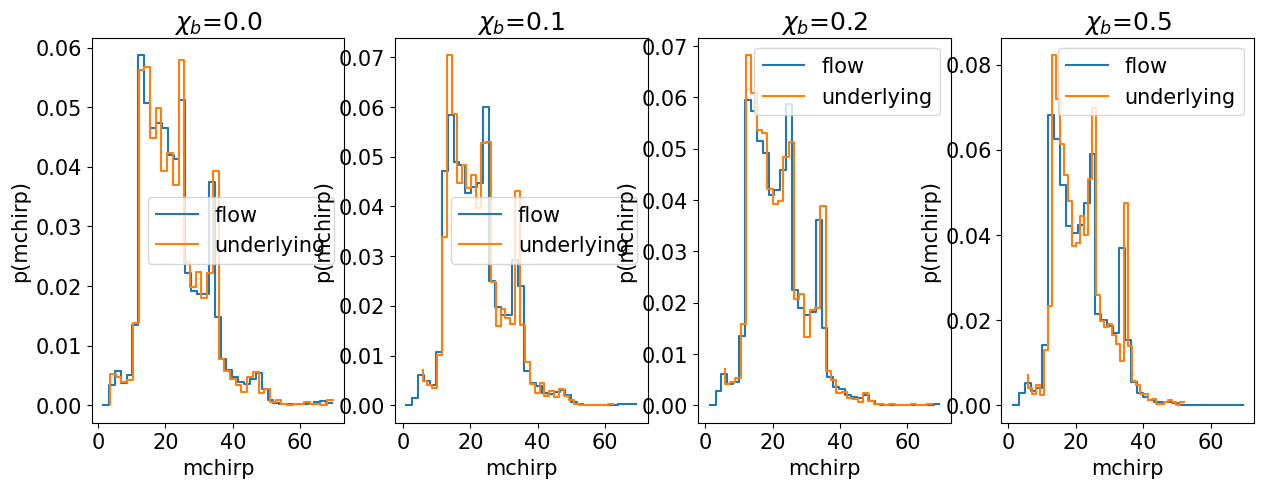

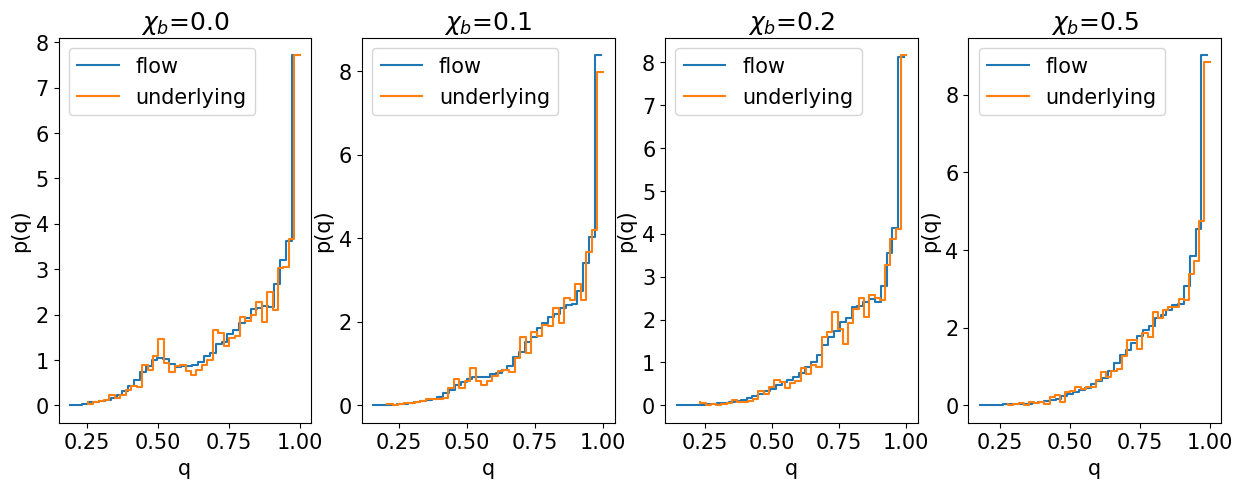

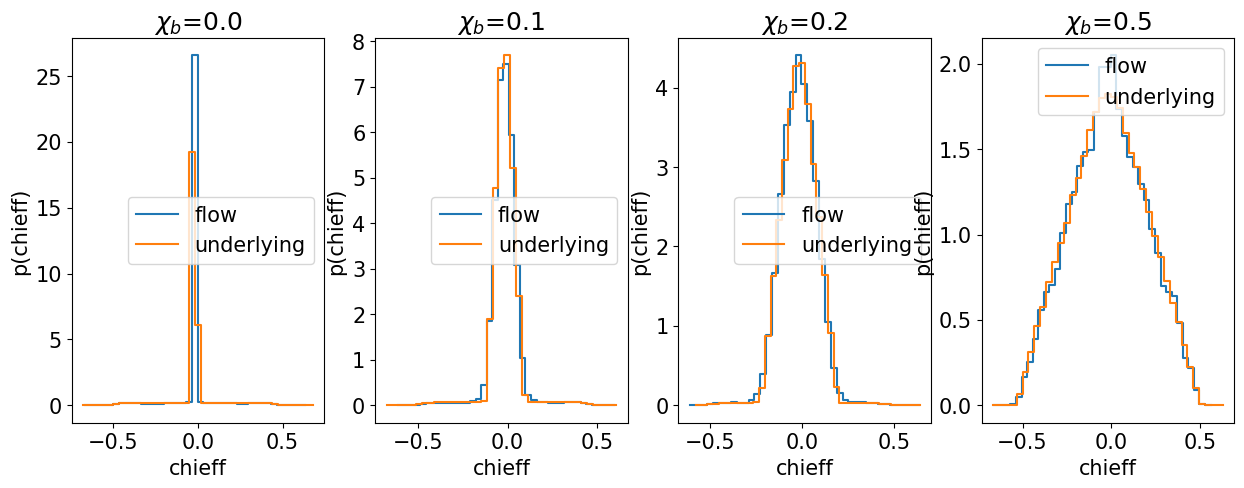

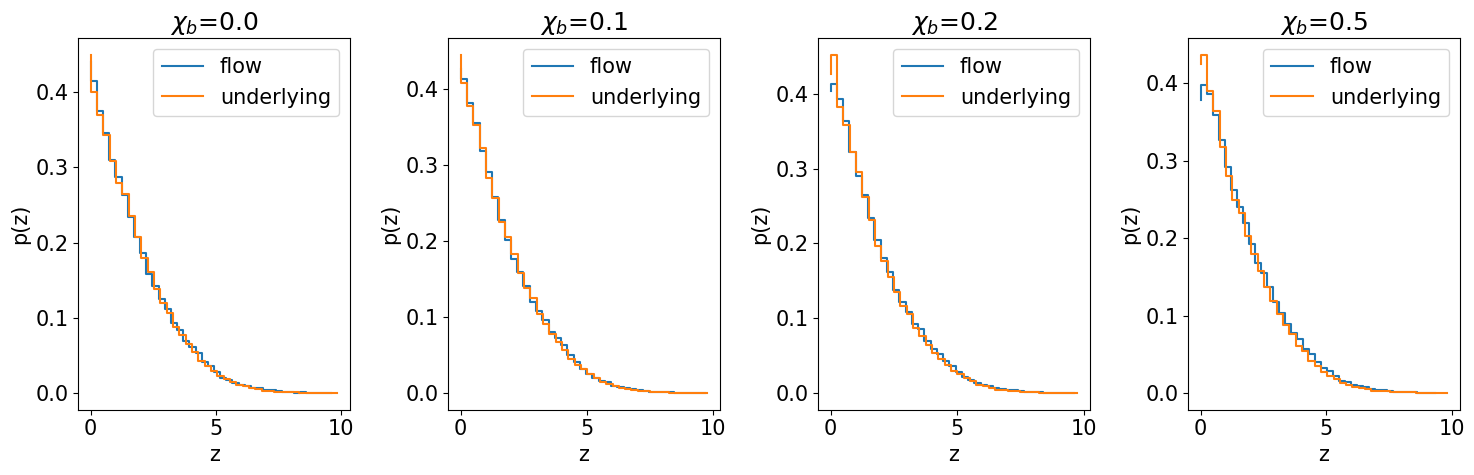

In [16]:
plt.rcParams["figure.figsize"] = (15,5)
no_samples = 100000
no_bins = 40

fig_mchirp, ax_m = plt.subplots(1,4)
fig_q, ax_q = plt.subplots(1,4)
fig_c, ax_c = plt.subplots(1,4)
fig_z, ax_z = plt.subplots(1,4)

for chi_b_id, xb in enumerate(chi_b):
    flow_samples_stack = flow.flow.sample(no_samples, np.array([xb]))
    flow_mchirp = flow.expistic(flow_samples_stack[:,0], flow.mappings[0], flow.mappings[1])
    flow_q = flow.expistic(flow_samples_stack[:,1], flow.mappings[2])
    flow_chieff = np.tanh(flow_samples_stack[:,2])
    flow_z = flow.expistic(flow_samples_stack[:,3], flow.mappings[4], flow.mappings[5])

    mapped_flow_samples = [flow_mchirp,flow_q,flow_chieff,flow_z]

    for i, ax in enumerate([ax_m,ax_q,ax_c,ax_z]):
        flow_distr, bin_edges = np.histogram(mapped_flow_samples[i], bins=no_bins, density=True)
        known_distr, bin_edges_known =np.histogram(models_dict[chi_b_id][:][param[i]], bins=no_bins, density=True)
        ax[chi_b_id].step(np.linspace(bin_edges[0],bin_edges[-1],no_bins),flow_distr, label='flow')
        ax[chi_b_id].step(np.linspace(bin_edges_known[0],bin_edges_known[-1],no_bins),known_distr,label='underlying')
        ax[chi_b_id].set_title(fr'$\chi_b$={xb}')
        ax[chi_b_id].set_xlabel(f'{param[i]}')
        ax[chi_b_id].set_ylabel(f'p({param[i]})')
        ax[chi_b_id].legend()
        plt.tight_layout()

## Weighted Flow distributions - nonCE

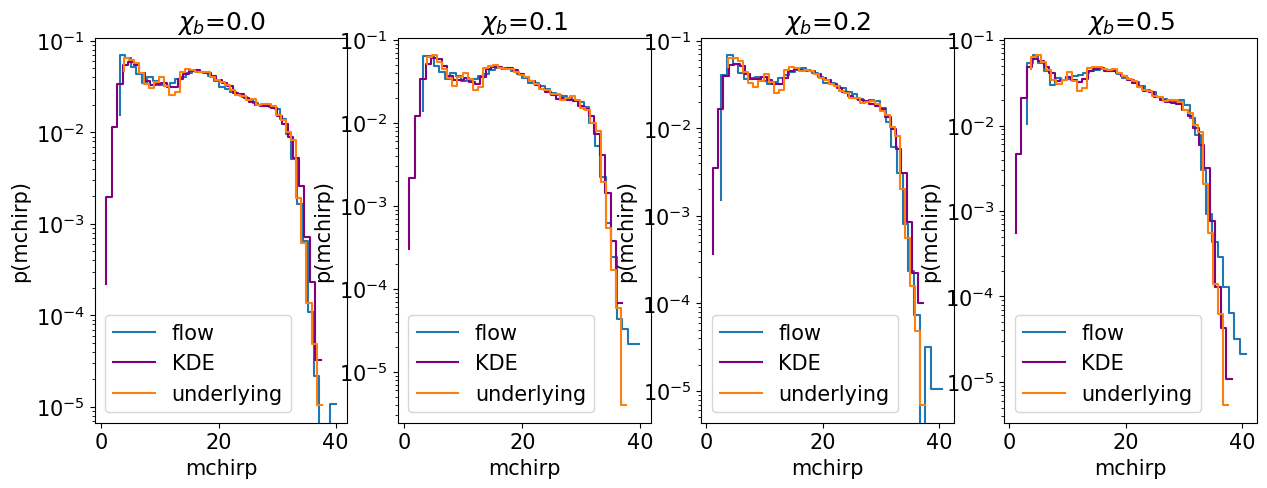

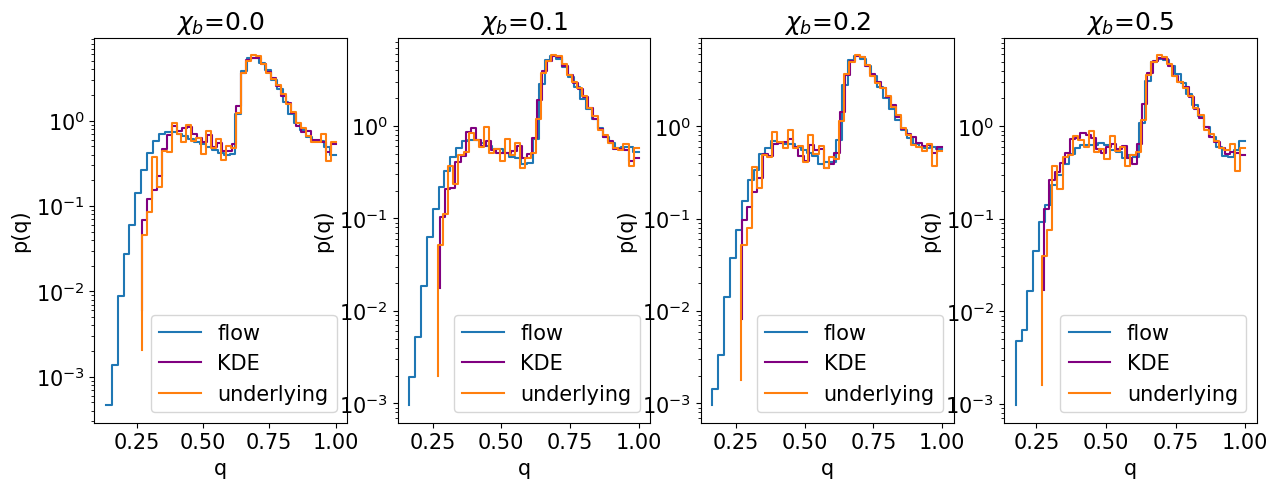

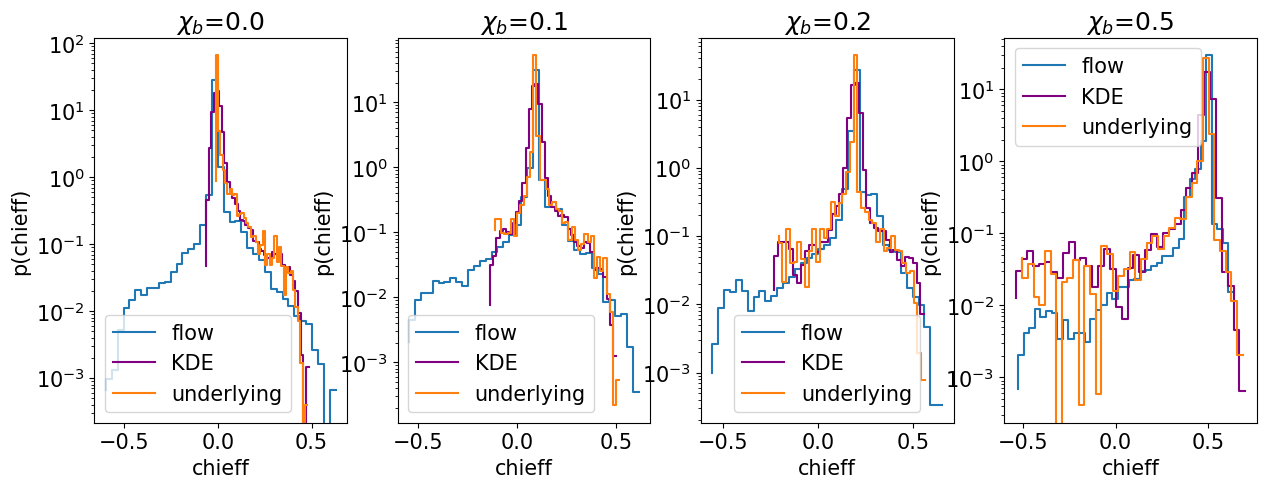

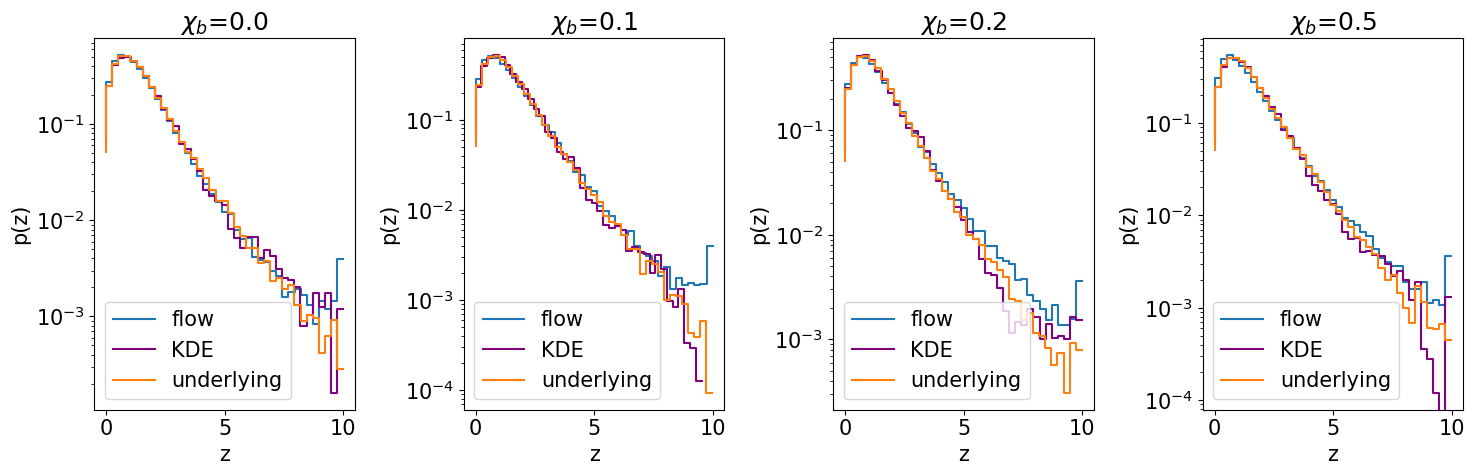

In [27]:
plt.rcParams["figure.figsize"] = (15,5)
no_samples = 100000
no_bins = 40

fig_mchirp, ax_m = plt.subplots(1,4)
fig_q, ax_q = plt.subplots(1,4)
fig_c, ax_c = plt.subplots(1,4)
fig_z, ax_z = plt.subplots(1,4)

for chi_b_id, xb in enumerate(chi_b):
    flow_samples_stack = weighted_flow.flow.sample(np.array([xb]),no_samples)
    flow_mchirp = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
    flow_q = weighted_flow.expistic(flow_samples_stack[:,1], weighted_flow.mappings[2])
    flow_chieff = np.tanh(flow_samples_stack[:,2])
    flow_z = weighted_flow.expistic(flow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])

    mapped_flow_samples = [flow_mchirp,flow_q,flow_chieff,flow_z]


    kde_samples = KDE_models['SMT'][submodels_dict[0][chi_b_id]].sample(no_samples)

    for i, ax in enumerate([ax_m,ax_q,ax_c,ax_z]):
        flow_distr, bin_edges = np.histogram(mapped_flow_samples[i], bins=no_bins, density=True)
        kde_distr, bin_edges_KDE = np.histogram(kde_samples[:,i], bins=no_bins, density=True)
        known_distr, bin_edges_known =np.histogram(models_dict[chi_b_id][:][param[i]], bins=no_bins, density=True, weights=weights_dict[chi_b_id])
        ax[chi_b_id].step(np.linspace(bin_edges[0],bin_edges[-1],no_bins),flow_distr, label='flow')
        ax[chi_b_id].step(np.linspace(bin_edges_KDE[0],bin_edges_KDE[-1],no_bins),kde_distr,label='KDE', color='purple')
        ax[chi_b_id].step(np.linspace(bin_edges_known[0],bin_edges_known[-1],no_bins),known_distr,label='underlying')
        ax[chi_b_id].set_title(fr'$\chi_b$={xb}')
        ax[chi_b_id].set_xlabel(f'{param[i]}')
        ax[chi_b_id].set_ylabel(f'p({param[i]})')
        ax[chi_b_id].set_yscale('log')
        ax[chi_b_id].legend()
        plt.tight_layout()

## Unweighted distributions - CE

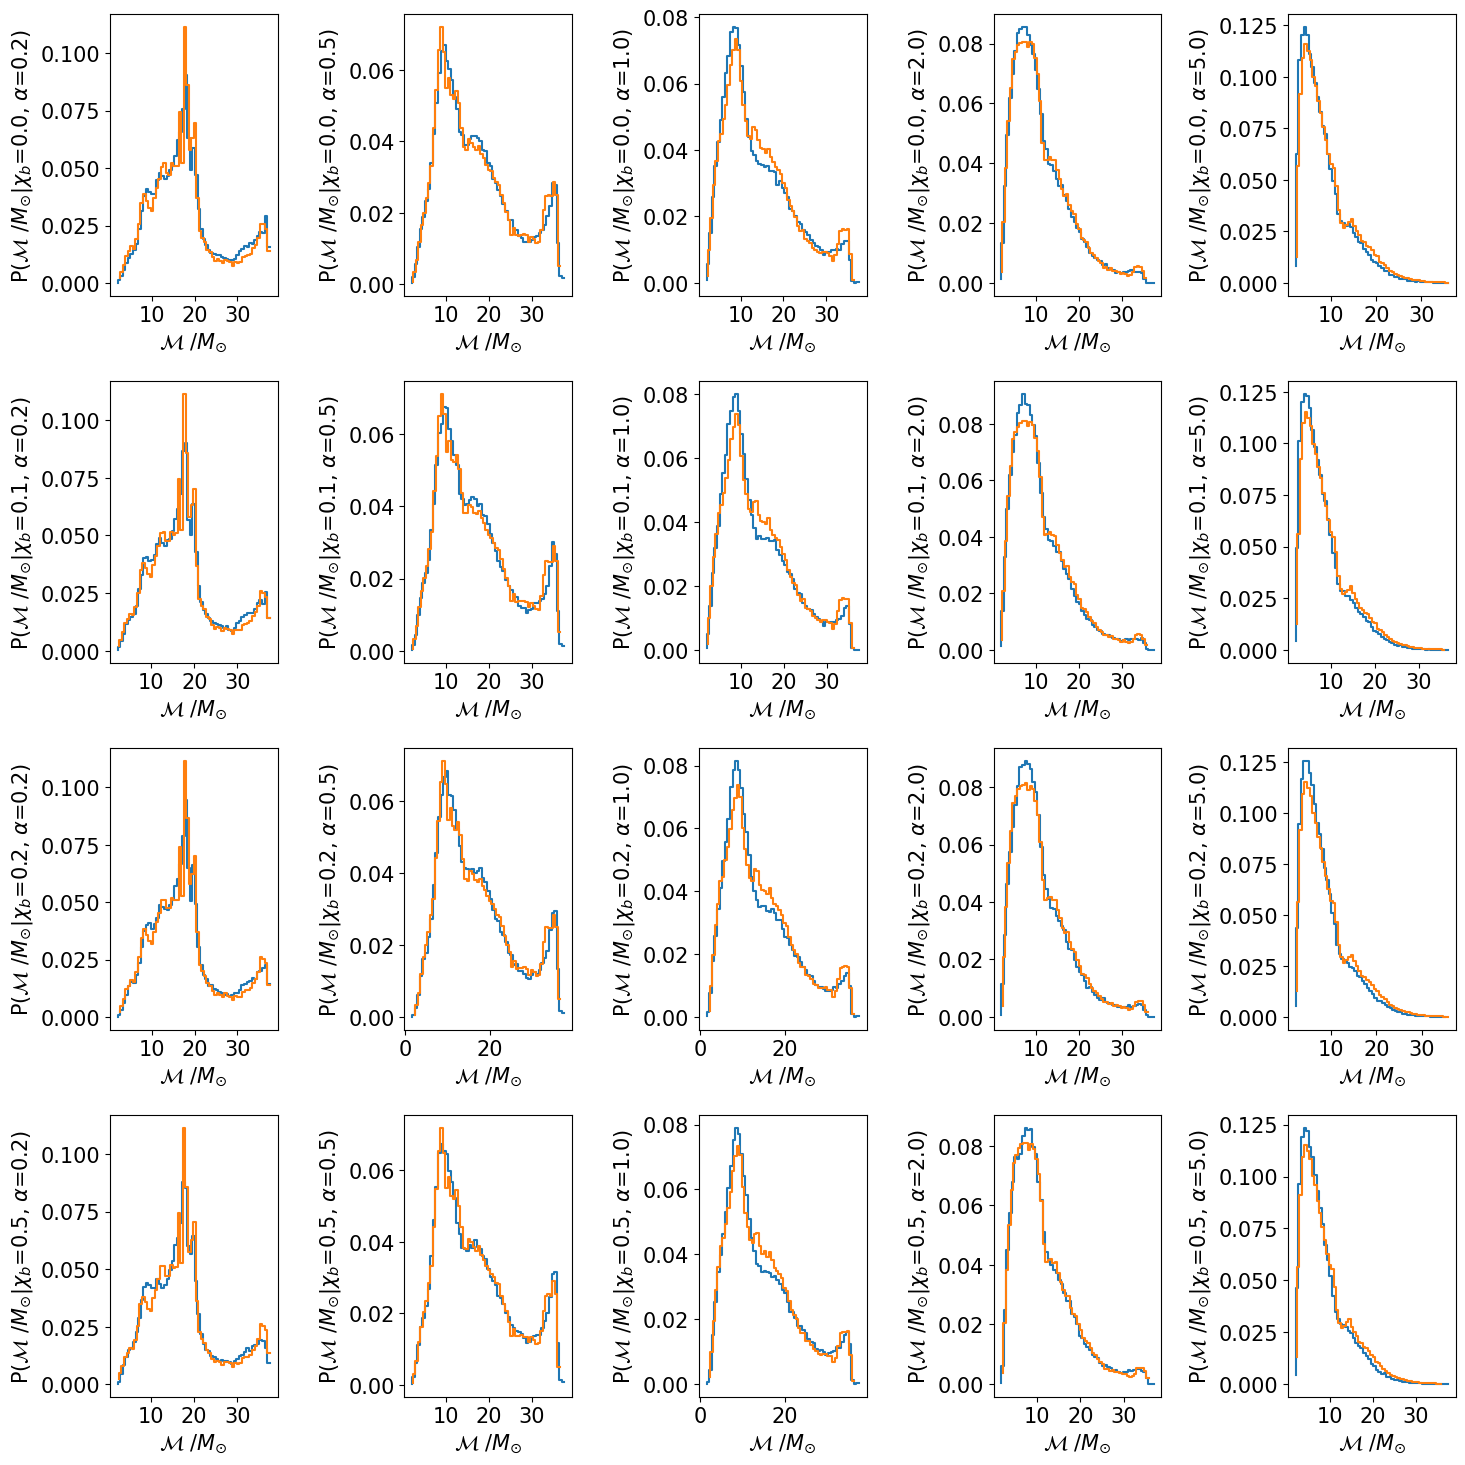

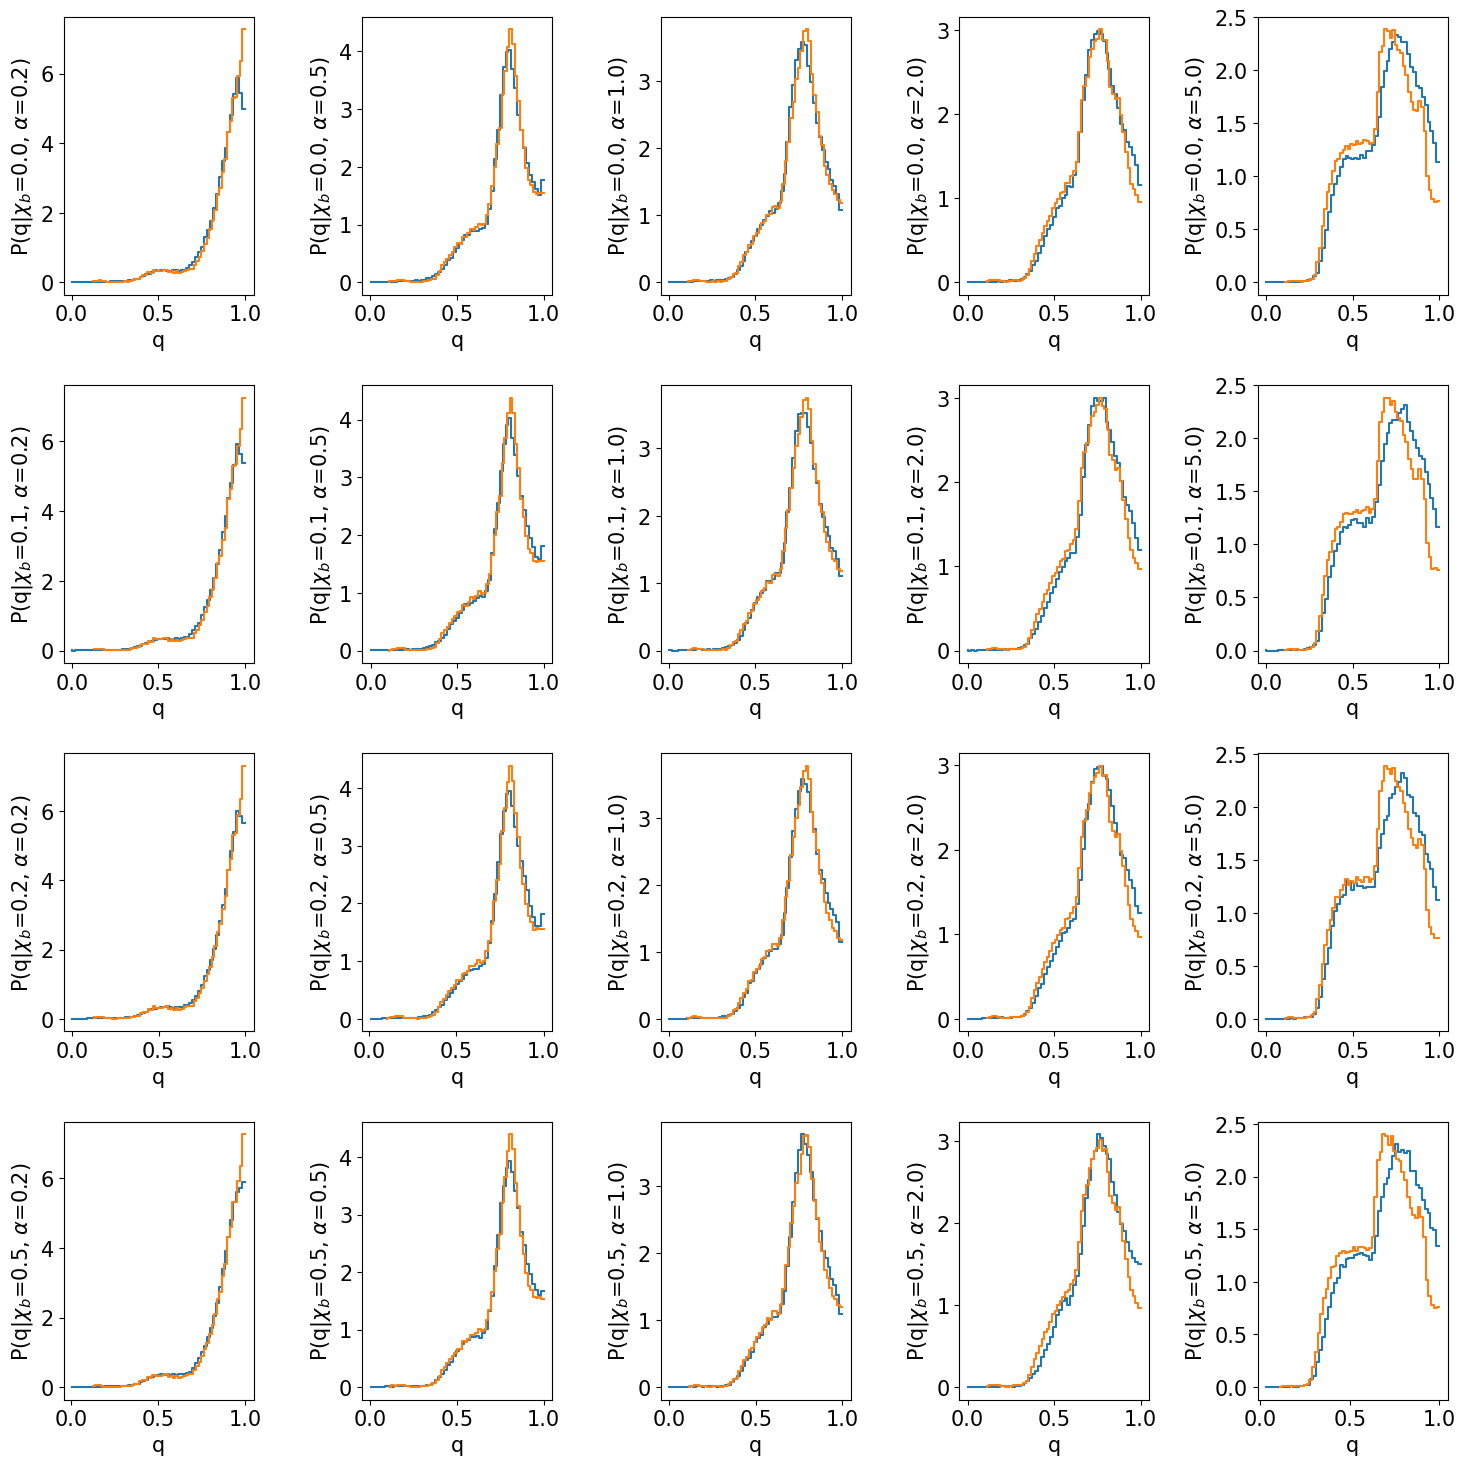

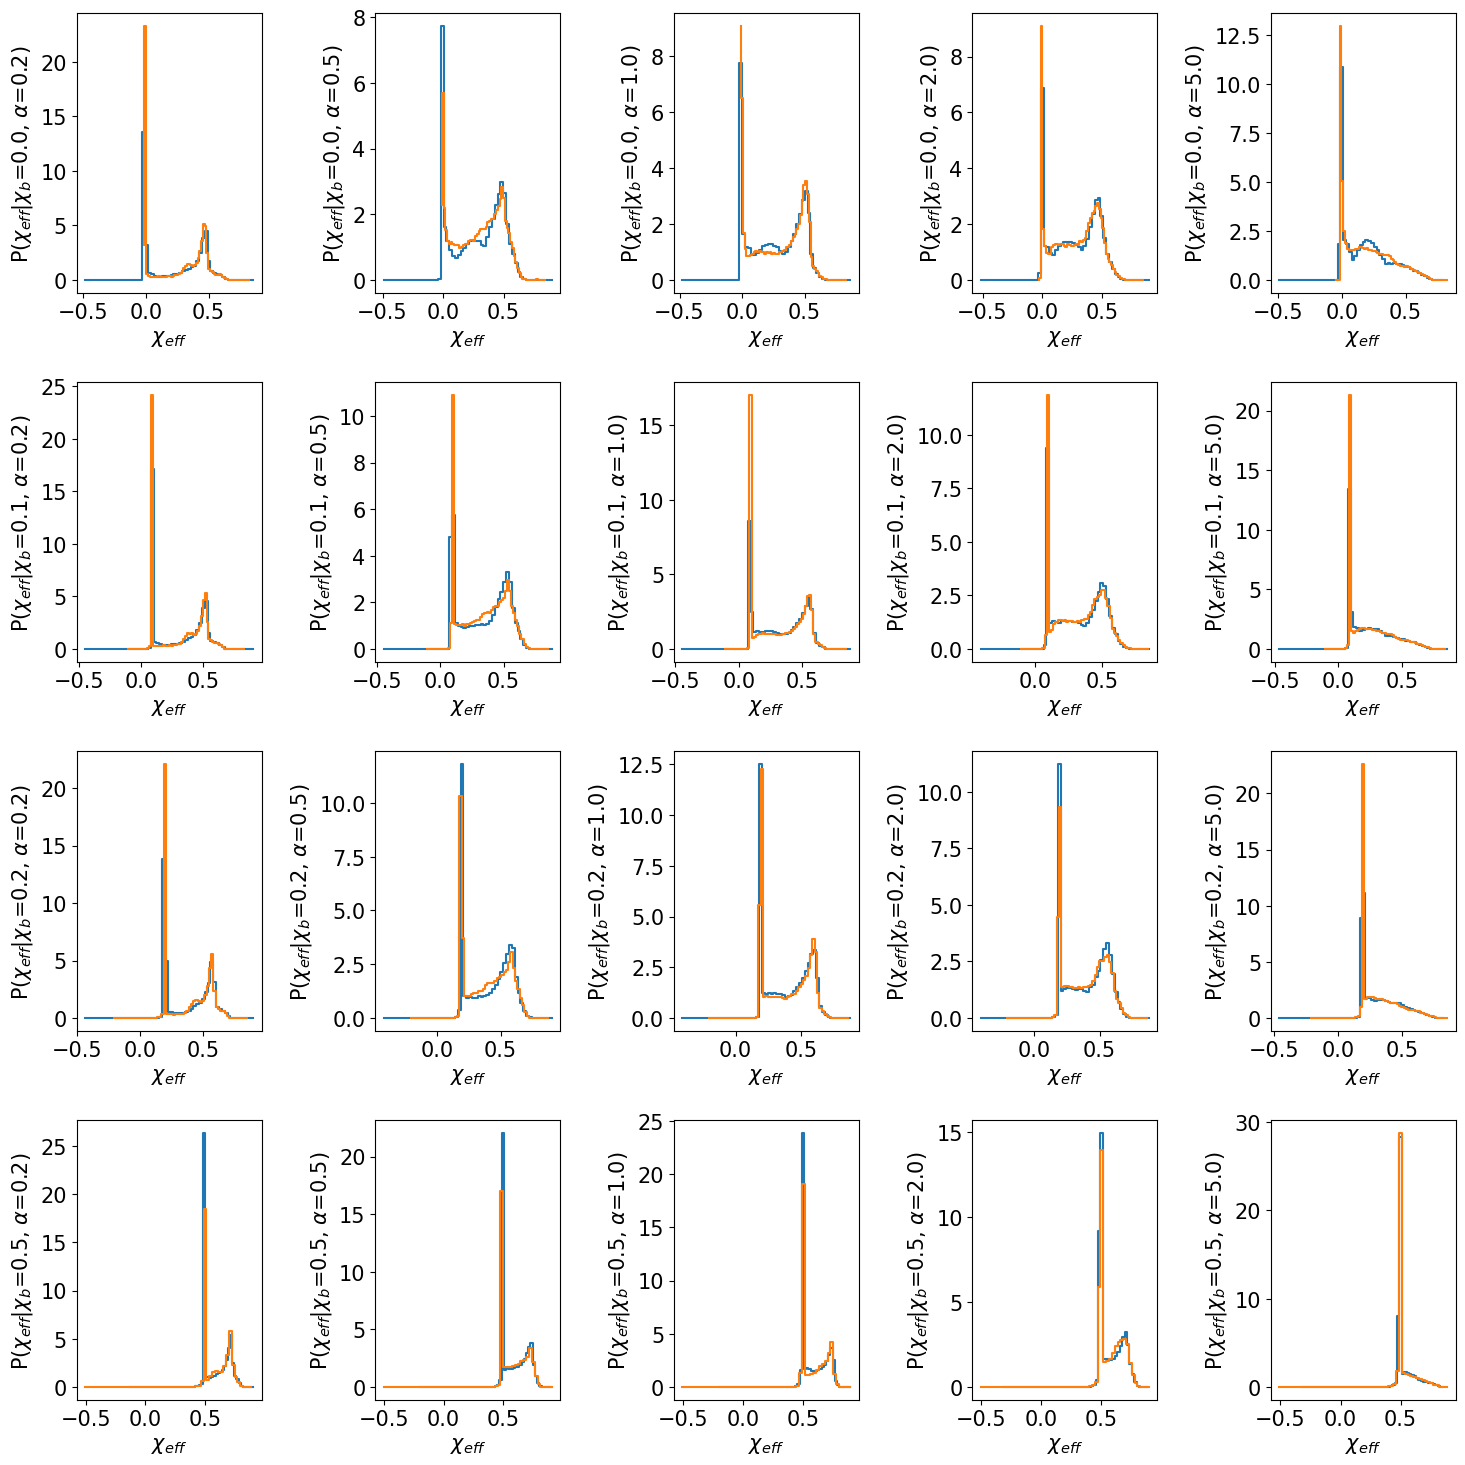

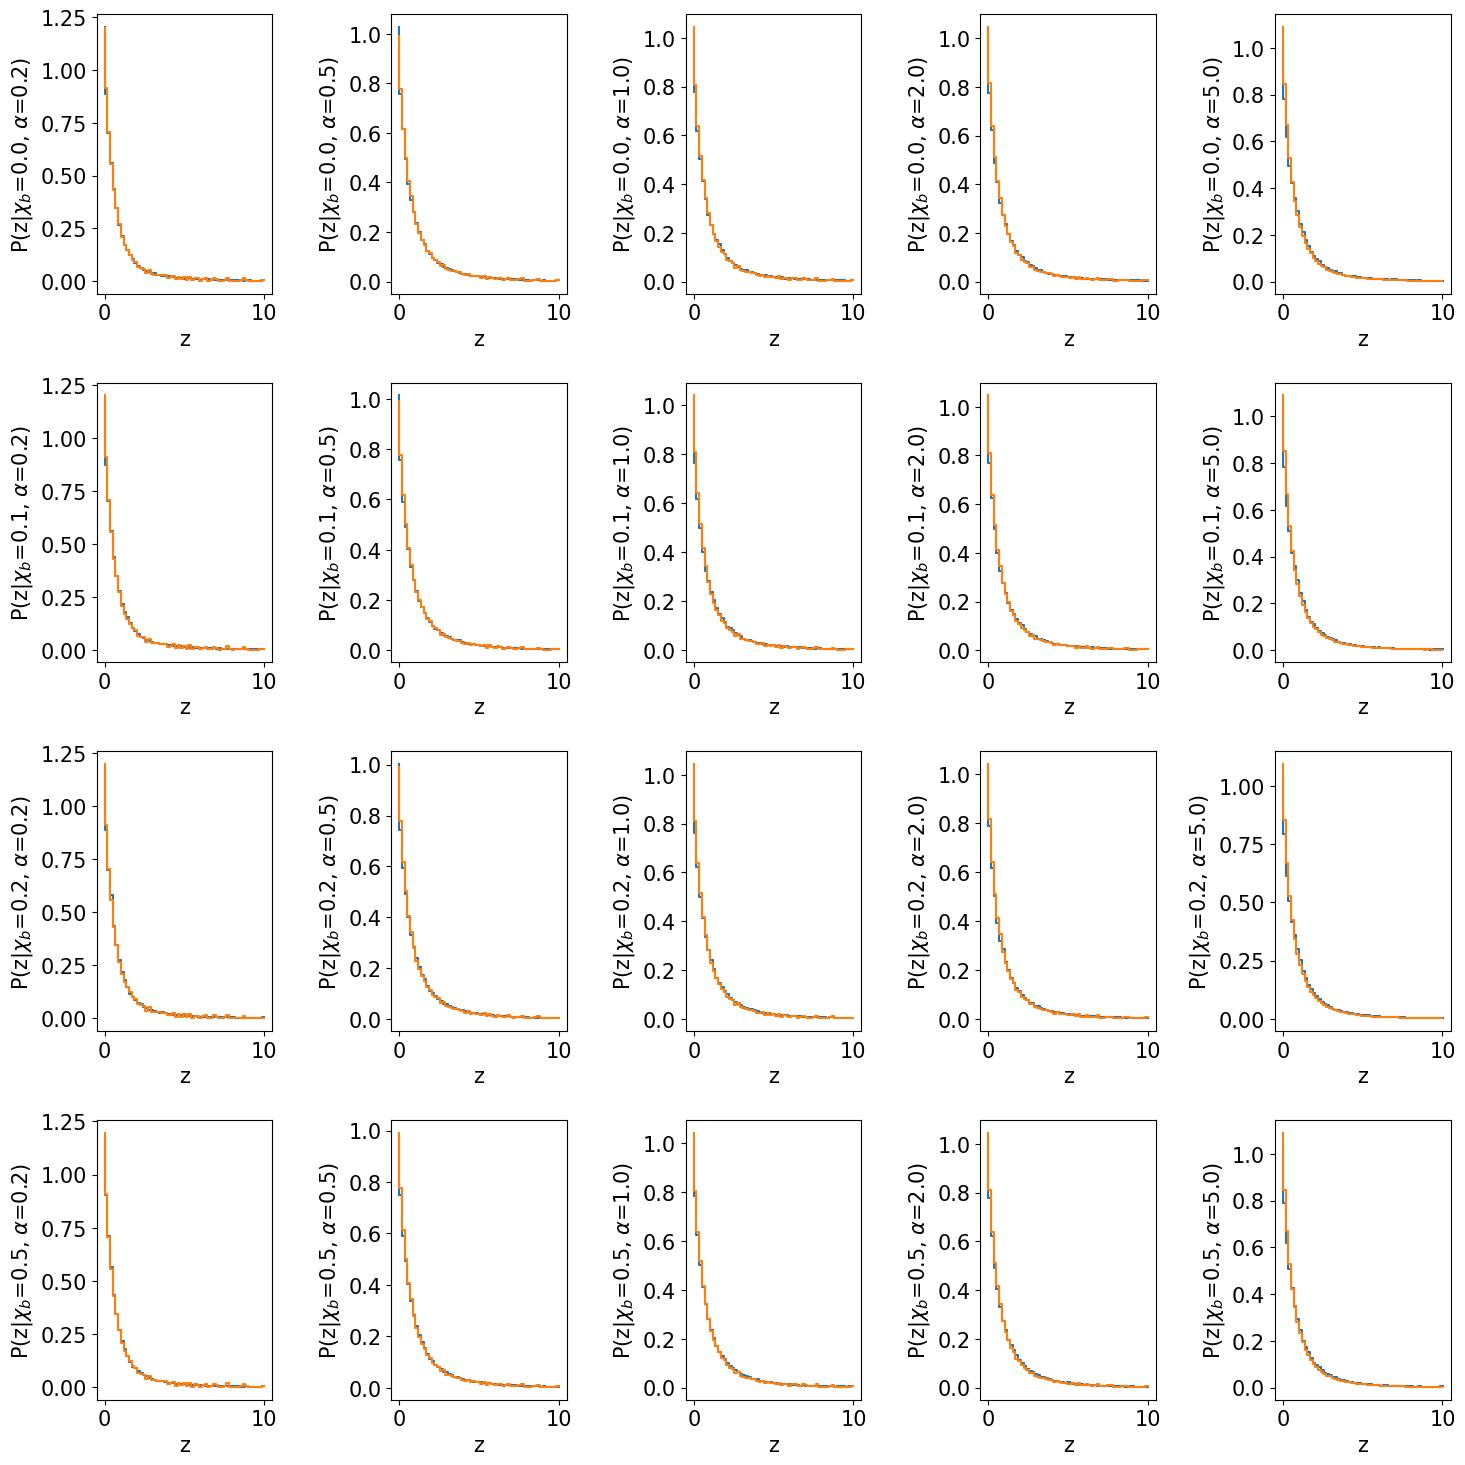

In [6]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
no_samples = 100000
no_bins = 60

fig_mchirp, ax_m = plt.subplots(4,5)
fig_q, ax_q = plt.subplots(4,5)
fig_c, ax_c = plt.subplots(4,5)
fig_z, ax_z = plt.subplots(4,5)

param_label = ['$\mathcal{M}$ /$M_{\odot}$','q', '$\chi_{eff}$', 'z']

for chi_b_id, xb in enumerate(chi_b):
    for alpha_id, a in enumerate(alpha_CE):
        flow_samples_stack = flow.flow.sample(no_samples, np.array([xb,a]))
        flow_mchirp = flow.expistic(flow_samples_stack[:,0], flow.mappings[0], flow.mappings[1])
        flow_q = flow.expistic(flow_samples_stack[:,1], flow.mappings[2])
        flow_chieff = np.tanh(flow_samples_stack[:,2])
        flow_z = flow.expistic(flow_samples_stack[:,3], flow.mappings[4], flow.mappings[5])

        mapped_flow_samples = [flow_mchirp,flow_q,flow_chieff,flow_z]

        for i, ax in enumerate([ax_m,ax_q,ax_c,ax_z]):
            flow_distr, bin_edges = np.histogram(mapped_flow_samples[i], bins=no_bins, density=True)
            known_distr, bin_edges_known =np.histogram(models_dict[(chi_b_id,alpha_id)][:][param[i]], bins=no_bins, density=True)
            ax[chi_b_id,alpha_id].step(np.linspace(bin_edges[0],bin_edges[-1],no_bins),flow_distr, label='flow')
            ax[chi_b_id,alpha_id].step(np.linspace(bin_edges_known[0],bin_edges_known[-1],no_bins),known_distr,label='underlying')
            #ax[chi_b_id,alpha_id].set_title(fr'$\chi_b$={xb} and $\alpha$={a}')
            ax[chi_b_id,alpha_id].set_xlabel(fr'{param_label[i]}')
            ax[chi_b_id,alpha_id].set_ylabel(fr'P({param_label[i]}|$\chi_b$={xb}, $\alpha$={a})')
            #ax[chi_b_id,alpha_id].legend()
            fig_mchirp.tight_layout(pad=1.3)
            fig_c.tight_layout(pad=1.3)
            fig_q.tight_layout(pad=1.3)
            fig_z.tight_layout(pad=1.3)

## Cosmo weighted Distributions - CE

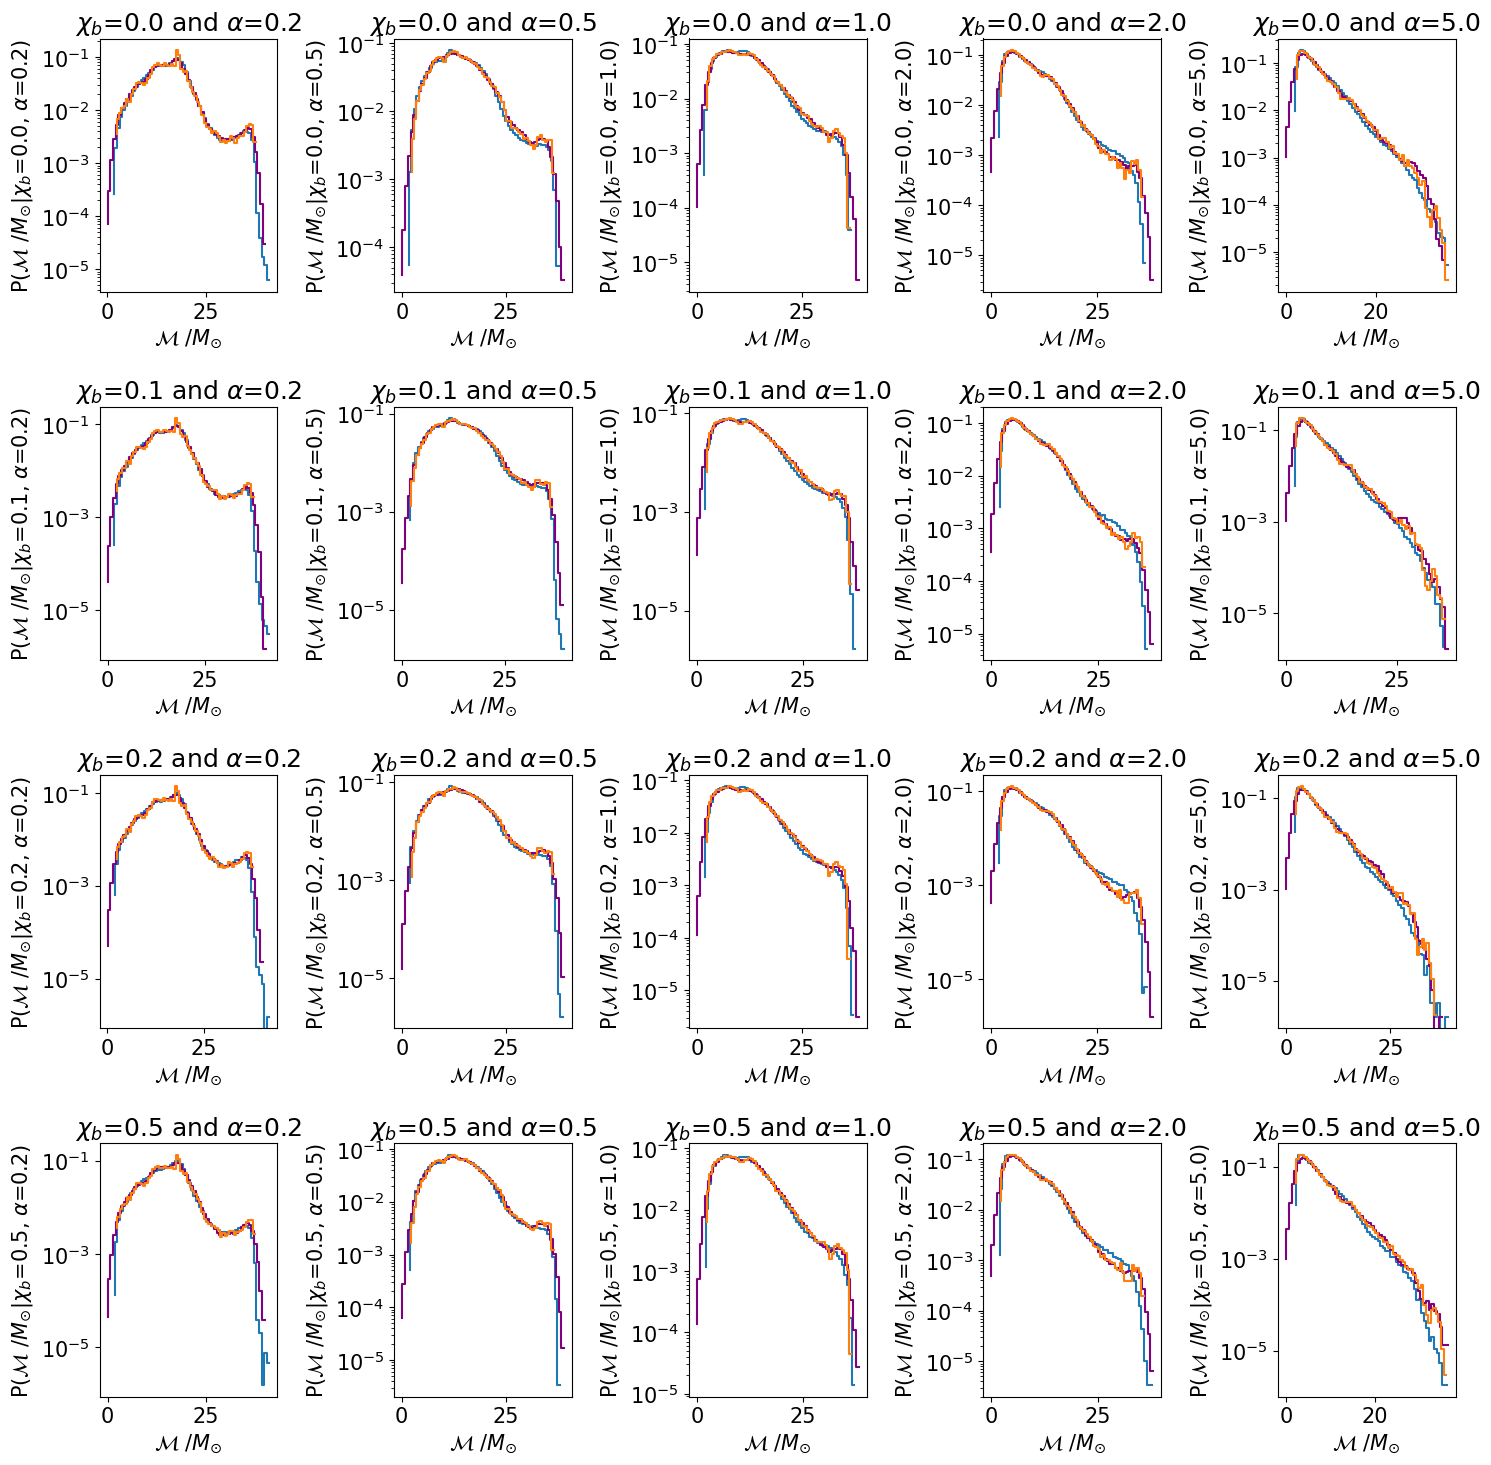

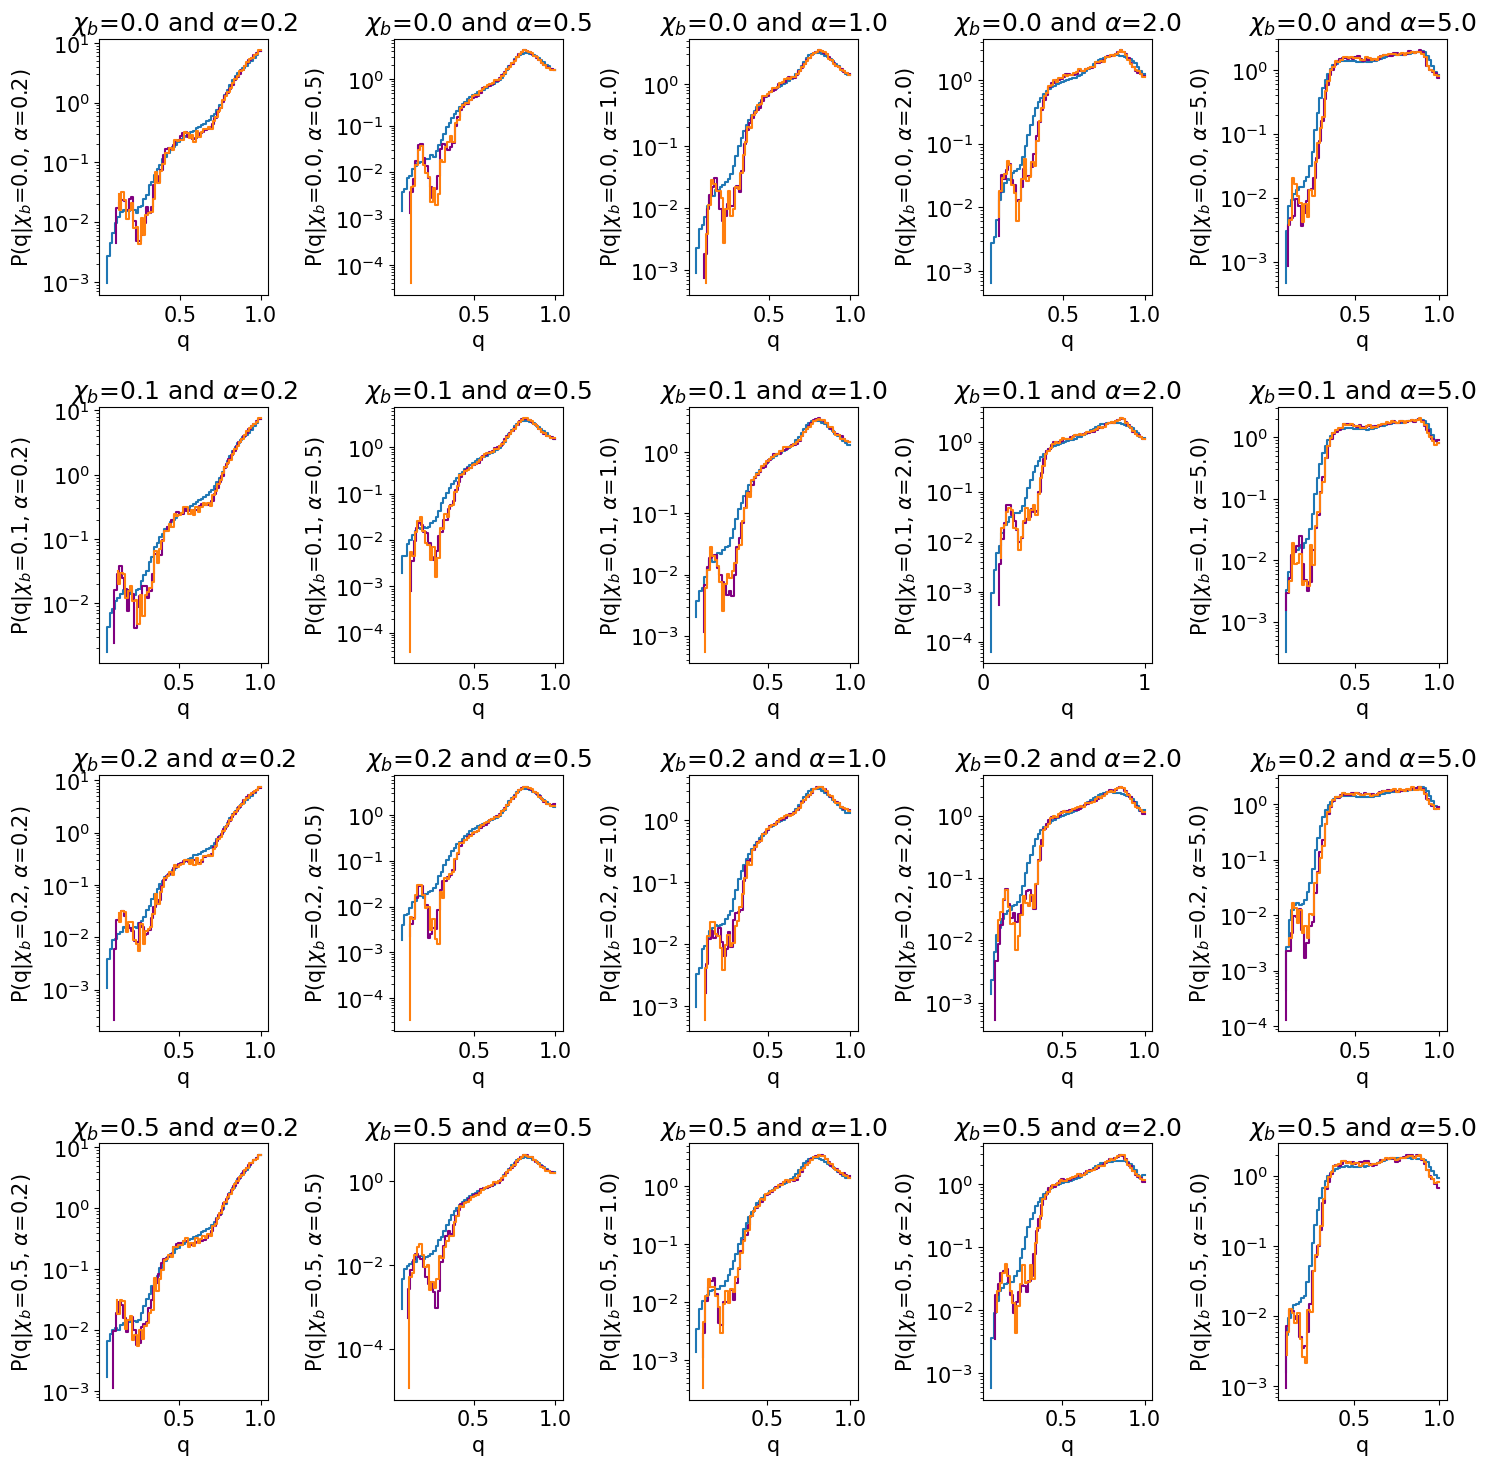

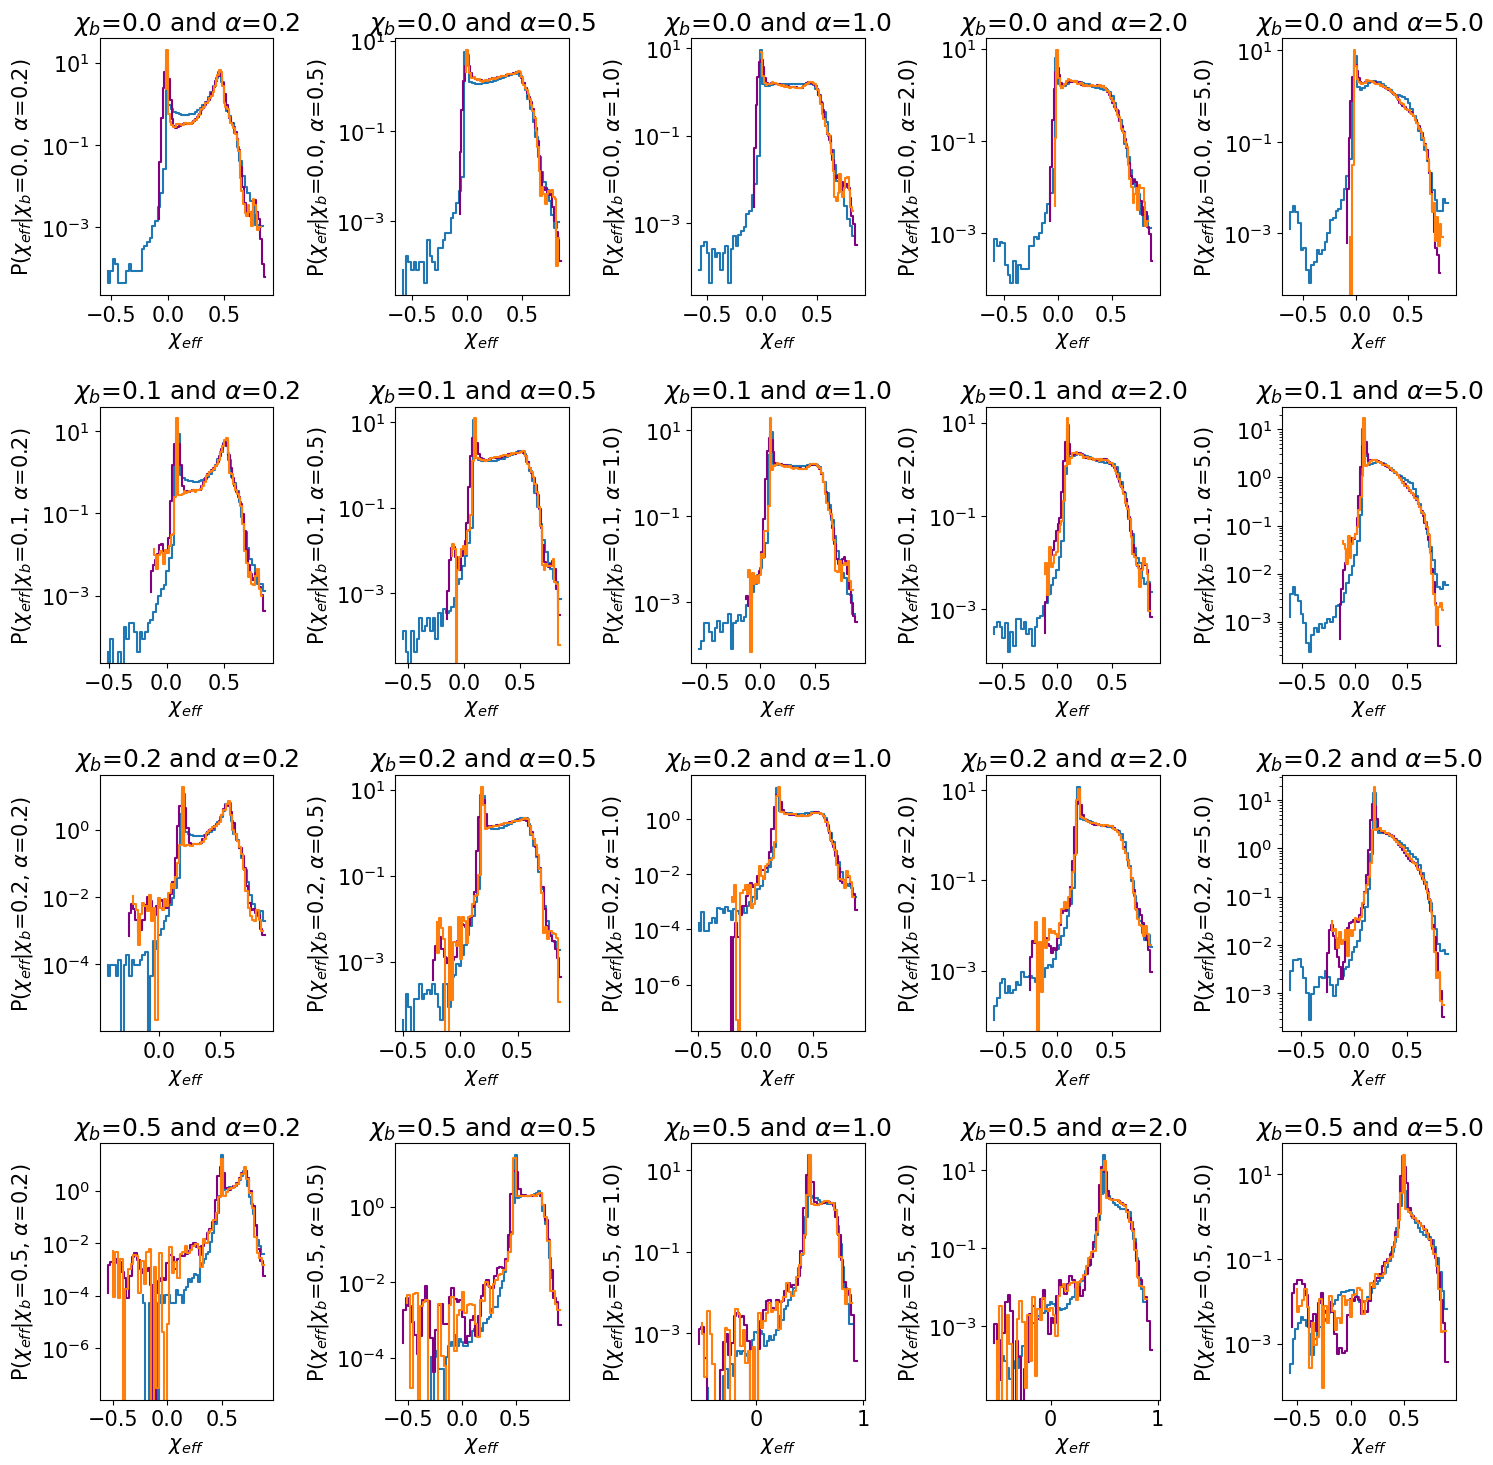

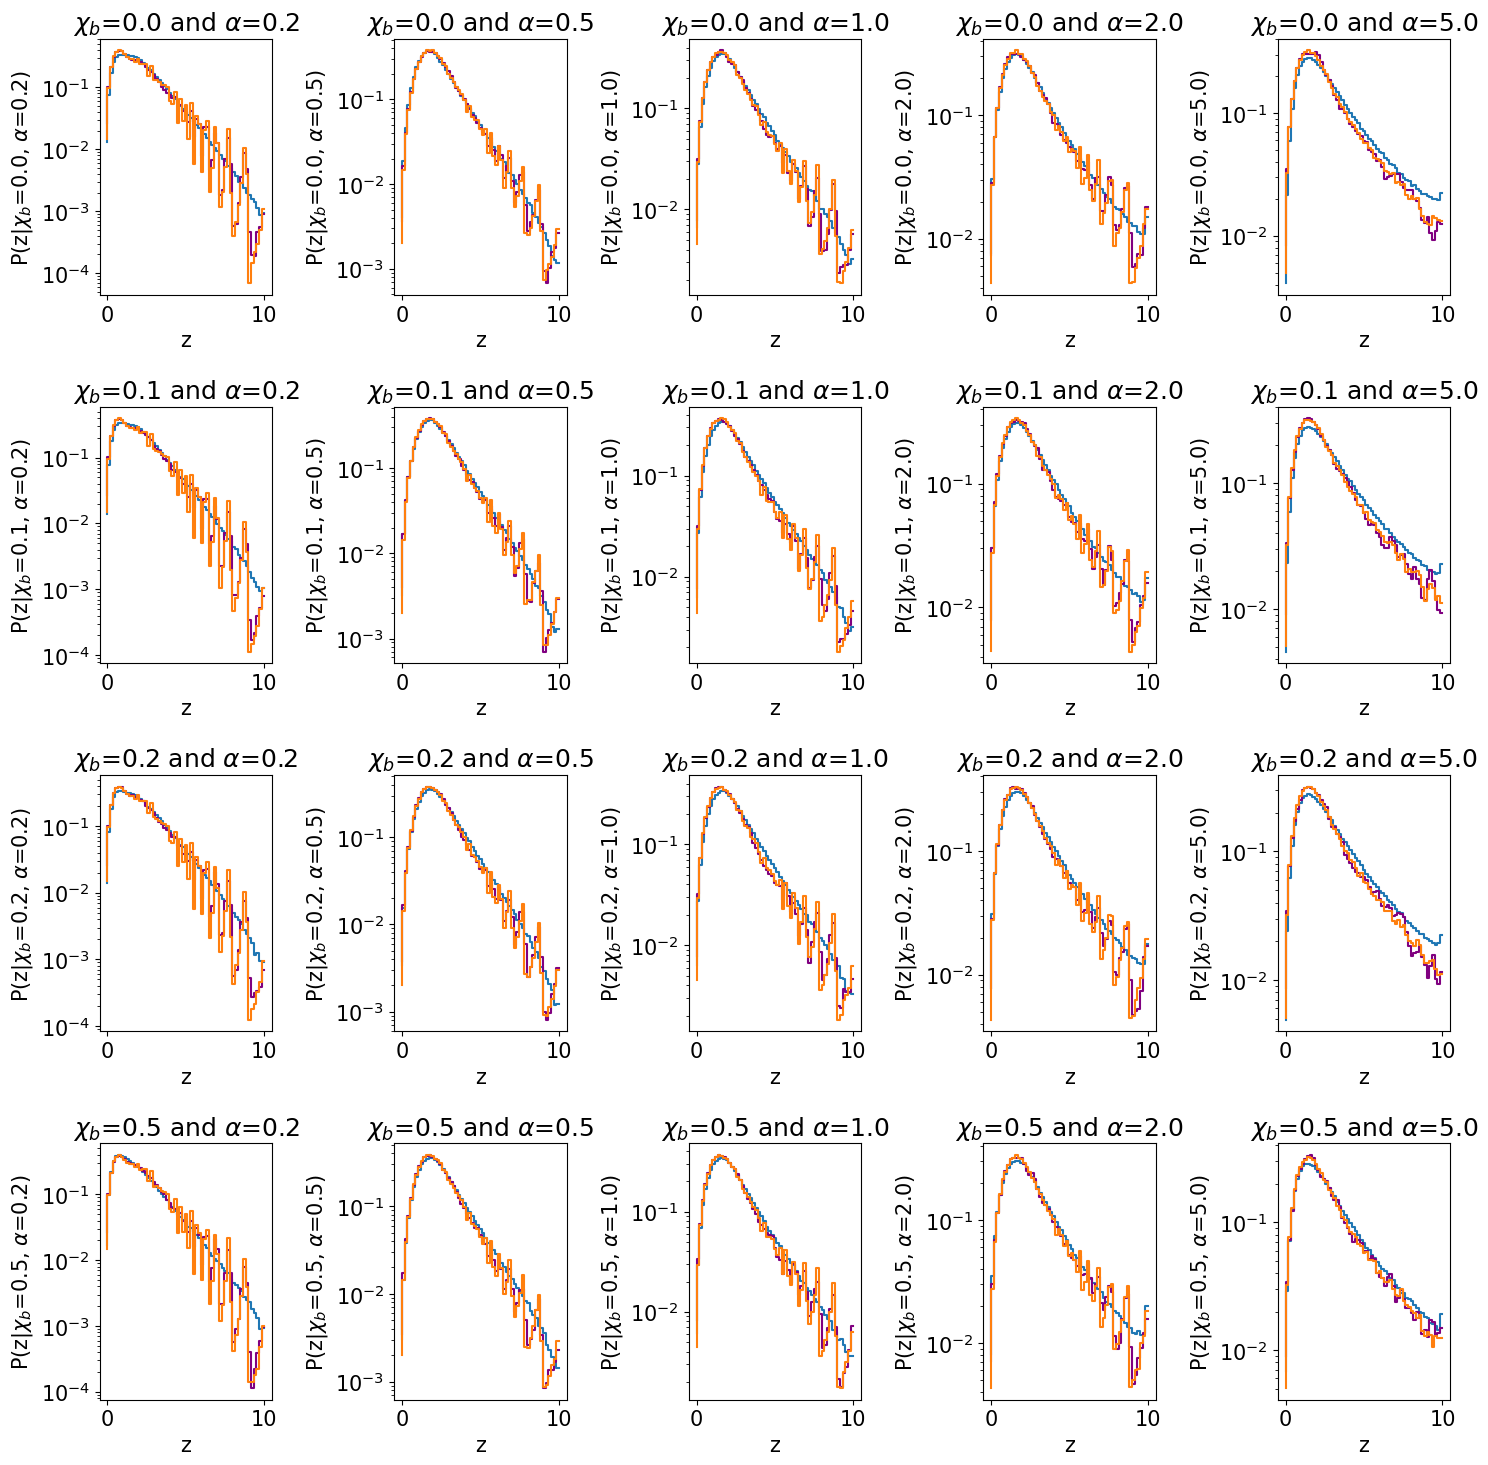

In [7]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
no_samples = 1000000
no_bins = 60

fig_mchirp, ax_m = plt.subplots(4,5)
fig_q, ax_q = plt.subplots(4,5)
fig_c, ax_c = plt.subplots(4,5)
fig_z, ax_z = plt.subplots(4,5)

param_label = ['$\mathcal{M}$ /$M_{\odot}$','q', '$\chi_{eff}$', 'z']

for chi_b_id, xb in enumerate(chi_b):
    for alpha_id, a in enumerate(alpha_CE):
        flow_samples_stack = weighted_flow.flow.sample(np.array([xb,a]), no_samples)
        flow_mchirp = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
        flow_q = weighted_flow.expistic(flow_samples_stack[:,1], weighted_flow.mappings[2])
        flow_chieff = np.tanh(flow_samples_stack[:,2])
        flow_z = weighted_flow.expistic(flow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])

        mapped_flow_samples = [flow_mchirp,flow_q,flow_chieff,flow_z]

        kde_samples = KDE_models['CE'][submodels_dict[0][chi_b_id]][submodels_dict[1][alpha_id]].sample(no_samples)

        for i, ax in enumerate([ax_m,ax_q,ax_c,ax_z]):
            flow_distr, bin_edges = np.histogram(mapped_flow_samples[i], bins=no_bins, density=True)
            kde_distr, bin_edges_KDE = np.histogram(kde_samples[:,i], bins=no_bins, density=True)
            known_distr, bin_edges_known =np.histogram(models_dict[(chi_b_id,alpha_id)][:][param[i]], bins=no_bins, density=True, weights=weights_dict[(chi_b_id,alpha_id)][:])
            ax[chi_b_id,alpha_id].step(np.linspace(bin_edges[0],bin_edges[-1],no_bins),flow_distr, label='flow')
            ax[chi_b_id,alpha_id].step(np.linspace(bin_edges_KDE[0],bin_edges_KDE[-1],no_bins),kde_distr,label='KDE', color='purple')
            ax[chi_b_id,alpha_id].step(np.linspace(bin_edges_known[0],bin_edges_known[-1],no_bins),known_distr,label='underlying')
            ax[chi_b_id,alpha_id].set_title(fr'$\chi_b$={xb} and $\alpha$={a}')
            ax[chi_b_id,alpha_id].set_xlabel(fr'{param_label[i]}')
            ax[chi_b_id,alpha_id].set_ylabel(fr'P({param_label[i]}|$\chi_b$={xb}, $\alpha$={a})')
            ax[chi_b_id,alpha_id].set_yscale('log')
            #ax[chi_b_id,alpha_id].legend()
            fig_mchirp.tight_layout(pad=1.3)
            fig_c.tight_layout(pad=1.3)
            fig_q.tight_layout(pad=1.3)
            fig_z.tight_layout(pad=1.3)

## Corner Plots for 1 subpop

In [17]:
corner_kwargs = dict(
    bins=64,
    smooth=0.9,
    color="teal",
    #quantiles=[0.16, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=True,
    plot_datapoints=True,
    fill_contours=True,
    show_titles=True,
    hist_kwargs=dict(density=True),
    labels=['mchirp','q','chieff','z'],
    axes_scale='log',
)

In [11]:
corner_kwargs_kde = dict(
    bins=64,
    smooth=0.9,
    color="purple",
    #quantiles=[0.16, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=True,
    plot_datapoints=True,
    fill_contours=True,
    show_titles=True,
    hist_kwargs=dict(density=True),
    labels=['mchirp','q','chieff','z'],
    axes_scale='log',
)

In [12]:

from copy import deepcopy

## Corner plot CE

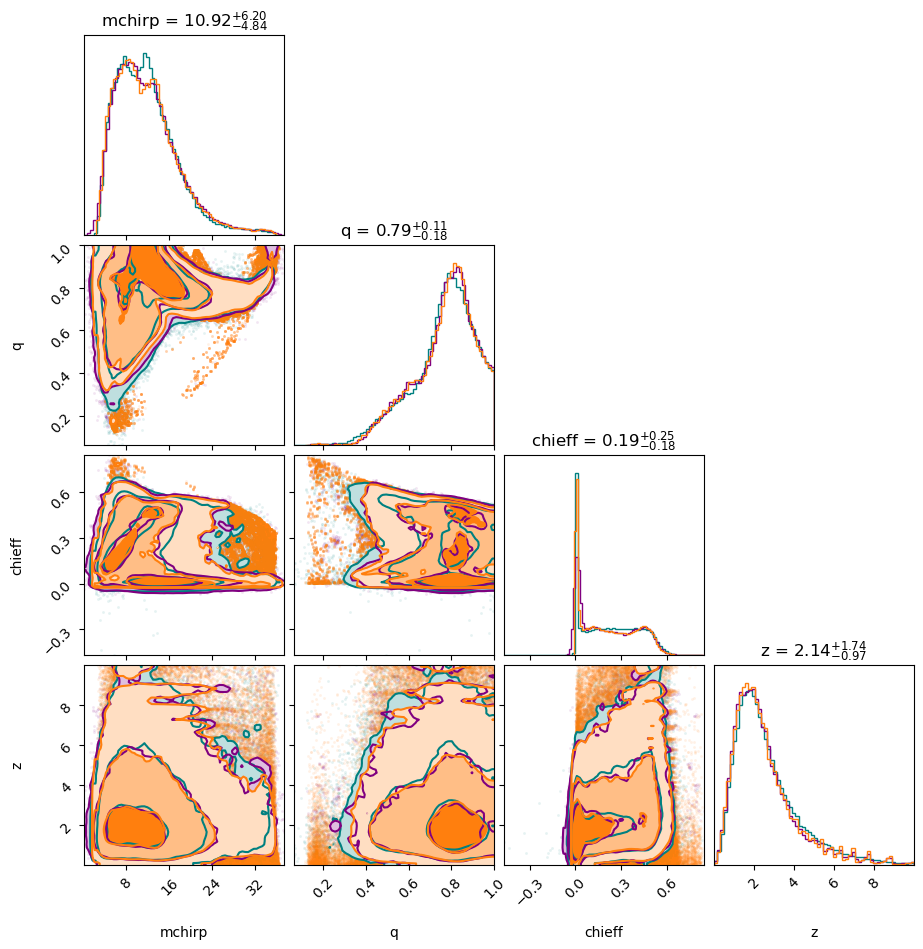

In [18]:
#sample flow
no_samples=100000
hyperparam_idxs = (0,2)
kwargs = deepcopy(corner_kwargs)
kwargs["color"] = "C1"
kwargs["hist_kwargs"]["color"] = "C1"

flow_samples_stack = weighted_flow.flow.sample(np.array([0.,1.]),no_samples)
flow_samples_stack[:,0] = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
flow_samples_stack[:,1] = weighted_flow.expistic(flow_samples_stack[:,1], weighted_flow.mappings[2])
flow_samples_stack[:,2] = np.tanh(flow_samples_stack[:,2])
flow_samples_stack[:,3] = weighted_flow.expistic(flow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])


kde_samples = KDE_models['CE'][submodels_dict[0][hyperparam_idxs[0]]][submodels_dict[1][hyperparam_idxs[1]]].sample(no_samples)

fig = corner.corner(flow_samples_stack.numpy(), **corner_kwargs)
fig =corner.corner(kde_samples, fig=fig, **corner_kwargs_kde)
fig =corner.corner(models_dict[hyperparam_idxs], fig=fig, weights=weights_dict[hyperparam_idxs][:], **kwargs)


## Corner plot non-CE

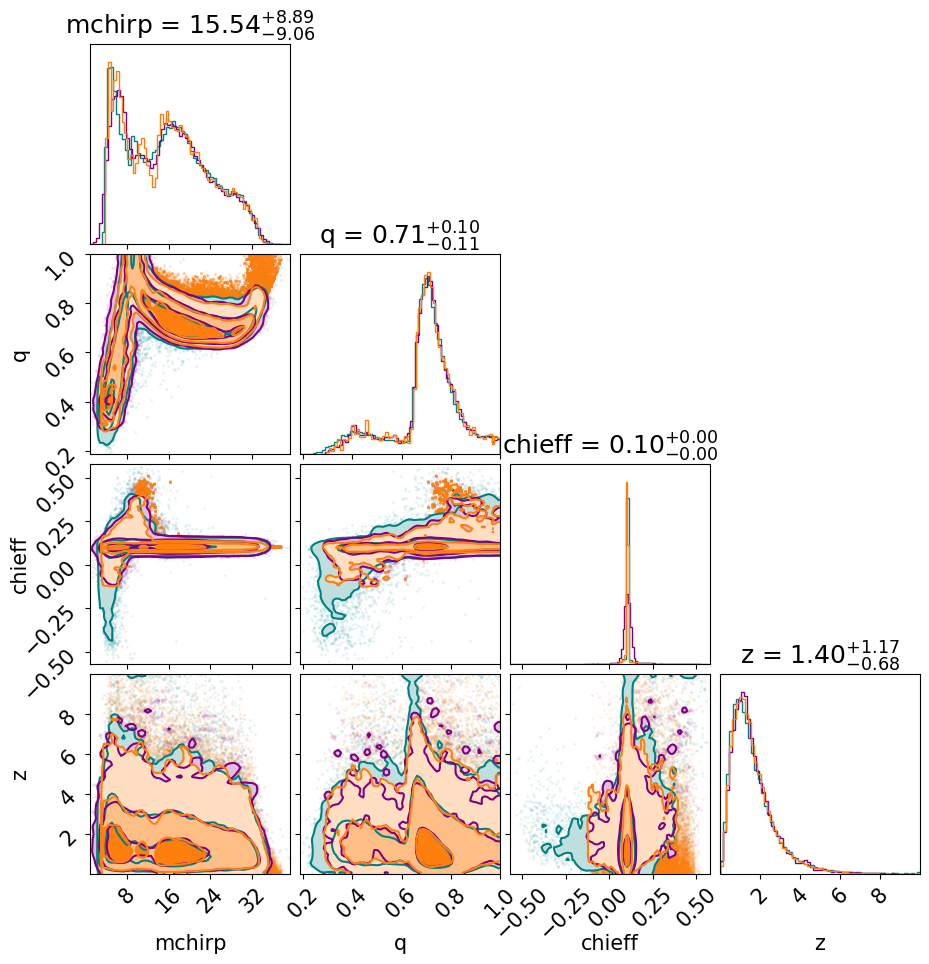

In [29]:
#sample flow
no_samples=100000
hyperparam_idxs = (1)
kwargs = deepcopy(corner_kwargs)
kwargs["color"] = "C1"
kwargs["hist_kwargs"]["color"] = "C1"
kwargs["axes_scale"] = "log"

flow_samples_stack = weighted_flow.flow.sample(np.array([0.1]), no_samples)
flow_samples_stack[:,0] = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
flow_samples_stack[:,1] = weighted_flow.expistic(flow_samples_stack[:,1], weighted_flow.mappings[2])
flow_samples_stack[:,2] = np.tanh(flow_samples_stack[:,2])
flow_samples_stack[:,3] = weighted_flow.expistic(flow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])


kde_samples = KDE_models[channel_label][submodels_dict[0][hyperparam_idxs]].sample(no_samples)

fig = corner.corner(flow_samples_stack.numpy(), **corner_kwargs)
fig =corner.corner(kde_samples, fig=fig, **corner_kwargs_kde)
fig =corner.corner(models_dict[hyperparam_idxs], fig=fig, weights=weights_dict[hyperparam_idxs][:], **kwargs)